In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc_stats

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})


## Function declarations

### Read `ods` to `DataFrame`


In [3]:
def read_ods(filename, columns):
  key_arr = (k for k in columns.keys())
  df = pd.read_excel(filename, engine="odf", header=0,
                     usecols=columns)
  df = df.rename(columns=columns)
  return df


### Get accuracy measures

In [4]:
def get_accuracy_measures(dataframe, columns=["Y_t", "hat_Y_t"]):
  Y_t = dataframe[columns[0]]
  hat_Y_t = dataframe[columns[1]]

  MAPE = (((Y_t - hat_Y_t).abs())/Y_t.abs()).mean()
  MAD = (Y_t - hat_Y_t).abs().mean()
  MSD = ((Y_t - hat_Y_t)**2).mean()
  
  return MAPE, MAD, MSD

  

### Standard error of autocorrelation


In [5]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


### Compute `r_k`, `t_test`, and `LBQ`

In [6]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result

### Plot of autocorrelation function

In [7]:
def plot_autocorr_func(df_acorr_analysis, title=None):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title(f"Autocorrelation Function for {title}\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


## Load the data

In [8]:
filename = "03-table-01-sales-of-saws-for-acme-tool.ods"
df = read_ods(filename, 
  {"t": "t", 
   "Sales": "Y_t"})

# add one additional row at the end of dataframe
# df.loc[len(df)] = [16, np.NaN]
num_of_quarters = 24
df_compute = df[:num_of_quarters]
df_test = df[num_of_quarters:]

df_compute

,t,Y_t
0,1,500
1,2,350
2,3,250
3,4,400
4,5,450
5,6,350
6,7,200
7,8,300
8,9,350
9,10,200


In [9]:
df_test

,t,Y_t
24,25,850
25,26,600
26,27,450
27,28,700


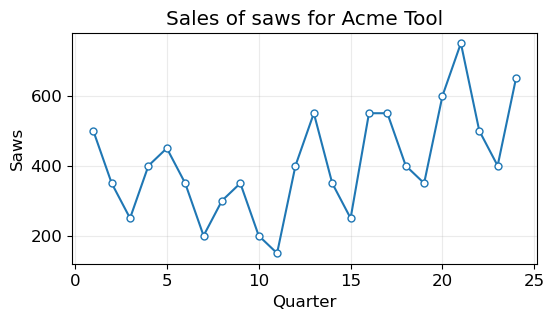

In [10]:
fig, ax = plt.subplots(figsize=(6, 3))

# exclude the last row
ax.plot(df_compute["t"], df_compute["Y_t"], marker='o', markersize=5, 
  markerfacecolor="white")
ax.set_xlabel("Quarter")
ax.set_ylabel("Saws")
ax.set_title("Sales of saws for Acme Tool")
ax.grid("on")
plt.show(fig)


## Forecasting (Holt's method = double exponential smoothed values)

The three equations used in Holt's method are
1. The exponentially smoothed series, or current level estimate
$$
  L_t = \alpha Y_t + (1 - \alpha)(L_{t-1} + T_{t-1})
$$

2. The trend estimate
$$
  T_t = \beta(L_t - L_{t-1}) + (1 - \beta) T_{t-1}
$$

3. The forecast for $p$ periods into the future
$$
  \hat{Y}_{t+p} = L_t + p\,T_t
$$

In [28]:
df_forecast = df_compute.copy()

init_L_t = df_forecast["Y_t"][0]
init_T_t = 0
Y_t = df_forecast["Y_t"].to_numpy()

alpha = 0.3 
beta = 0.1
p = 1

num_of_rows = len(Y_t)
L_t = np.empty(num_of_rows)
T_t = np.empty(num_of_rows)
L_t[0] = init_L_t
T_t[0] = init_T_t

for i in range(1, len(df_forecast)):
  L_t[i] = alpha*Y_t[i] + (1-alpha)*(L_t[i-1] + T_t[i-1]) 
  T_t[i] = beta*(L_t[i] - L_t[i-1]) + (1 - beta) * T_t[i-1]


df_forecast["L_t"] = L_t
df_forecast["T_t"] = T_t

# add one additional row at the end of dataframe
df_forecast.loc[num_of_rows] = [25, np.NaN, np.NaN, np.NaN]
df_forecast[f"hat_Y_tP{p}"] = (df_forecast["L_t"] + p*df_forecast["T_t"]).shift(1)
df_forecast["e_t"] = df_forecast["Y_t"] - df_forecast[f"hat_Y_tP{p}"]

df_forecast


,t,Y_t,L_t,T_t,hat_Y_tP1,e_t
0,1.0,500.0,500.000000,0.000000,NaN,NaN
1,2.0,350.0,455.000000,-4.500000,500.000000,-150.000000
2,3.0,250.0,390.350000,-10.515000,450.500000,-200.500000
3,4.0,400.0,385.884500,-9.910050,379.835000,20.165000
4,5.0,450.0,398.182115,-7.689284,375.974450,74.025550
5,6.0,350.0,378.344982,-8.904068,390.492831,-40.492831
6,7.0,200.0,318.608640,-13.987296,369.440914,-169.440914
7,8.0,300.0,303.234941,-14.125936,304.621344,-4.621344
8,9.0,350.0,307.376303,-12.299206,289.109004,60.890996
9,10.0,200.0,266.553968,-15.151519,295.077097,-95.077097
